<a href="https://colab.research.google.com/github/gani88/CrackDetectionInPainting/blob/main/CrackDetectionPaintingV2_(w_Image_Augmentation_%26_Transformation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Unzip File Dataset
import zipfile

local_zip = '/content/PaintingDataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()

zip_ref.close()

In [2]:
import os

base_dir = '/content/Painting Dataset'

print("Contents of base directory:")
print(os.listdir(base_dir))

print("\nContents of train directory:")
print(os.listdir(f'{base_dir}/Training'))

print("\nContents of validation directory:")
print(os.listdir(f'{base_dir}/Validation'))

Contents of base directory:
['Training', 'Validation']

Contents of train directory:
['Crack', 'NonCrack']

Contents of validation directory:
['Crack', 'NonCrack']


In [3]:
import os

train_dir = os.path.join(base_dir, 'Training')
validation_dir = os.path.join(base_dir, 'Validation')

# Directory with training crack and noncrack images pictures
train_noncrack_dir = os.path.join(train_dir, 'NonCrack')
train_crack_dir = os.path.join(train_dir, 'Crack')

# Directory with validation crack and noncrack images pictures
validation_noncrack_dir = os.path.join(validation_dir, 'NonCrack')
validation_crack_dir = os.path.join(validation_dir, 'Crack')

In [4]:
train_noncrack_fnames = os.listdir( train_noncrack_dir )
train_crack_fnames = os.listdir( train_crack_dir )

print("Non Crack Painting : ", train_noncrack_fnames[:10])
print("Crack Painting : ", train_crack_fnames[:10])

Non Crack Painting :  ['0059.jpg', '0147.jpg', '0173.jpg', '0272.jpg', '0122.jpg', '0114.jpg', '0312.jpg', '0384.jpg', '0172.jpg', '0021.jpg']
Crack Painting :  ['4ermine.jpg', '09monte4.jpg', 'crucifix.jpg', '37entom0.jpg', '07apollo.jpg', '04portma.jpg', 'healing2.jpg', '03fortu1.jpg', 'crucifiy.jpg', 'annunci3.jpg']


In [5]:
print('total training NonCrack images :', len(os.listdir(      train_noncrack_dir ) ))
print('total training Crack images :', len(os.listdir(      train_crack_dir ) ))

print('total validation NonCrack images :', len(os.listdir( validation_noncrack_dir ) ))
print('total validation Crack images :', len(os.listdir( validation_crack_dir ) ))

total training NonCrack images : 240
total training Crack images : 240
total validation NonCrack images : 60
total validation Crack images : 60


In [6]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt


nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

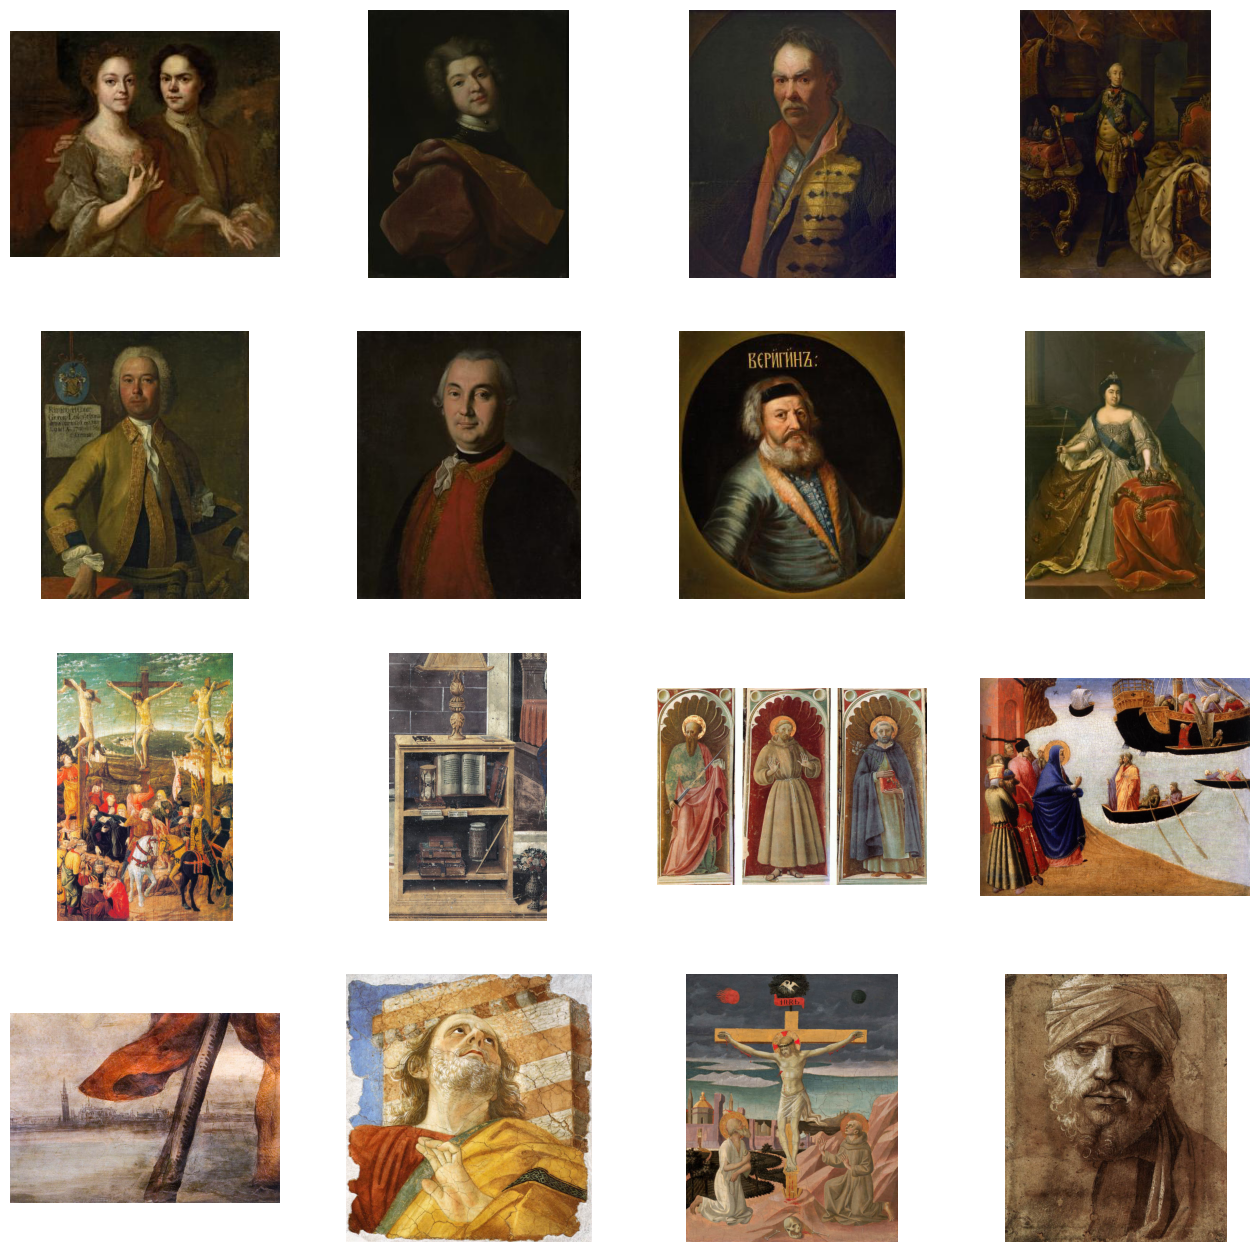

In [8]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_noncrack_pix = [os.path.join(train_noncrack_dir, fname) 
                for fname in train_noncrack_fnames[ pic_index-8:pic_index] 
               ]

next_crack_pix = [os.path.join(train_crack_dir, fname) 
                for fname in train_crack_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_noncrack_pix+next_crack_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [85]:
# Data Preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# rescale 1/255
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(500, 500))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (500, 500))

Found 480 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [96]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the custom preprocessing function
def custom_preprocessing(img):
    # Define the kernel size for the top-hat transform
    kernel_size = 10
    # Define the structuring element for the top-hat transform
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    # Perform the top-hat transform to enhance the contrast of the cracks
    tophat = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel)
    # Define the kernel size for the dilation operation
    kernel_size = 3
    # Define the structuring element for the dilation operation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    # Perform the dilation operation to expand the boundaries of the cracks
    dilated = cv2.dilate(tophat, kernel)
    # Return the preprocessed image
    return dilated

# Define the data generators for training and validation data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=custom_preprocessing
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=custom_preprocessing
)

# Load the training and validation data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)


Found 480 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [97]:
# Model
import tensorflow as tf

model = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('noncrack') and 1 for the other ('crack')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [98]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 17, 17, 64)      

In [111]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [13]:
!pip install tensorflow-addons==0.16.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.1 MB/s eta 0:00:00


In [99]:
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow_addons as tfa

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.Precision(), tfa.metrics.F1Score(1)])

In [ ]:
history = model.fit(
            train_generator,
            epochs=10,
            validation_data=validation_generator,
            verbose=1
            )

In [112]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    verbose=1
)

Epoch 1/10
24/24 [==============================] - 9s 319ms/step - loss: 0.4300 - accuracy: 0.9563 - val_loss: 0.0748 - val_accuracy: 0.9750
Epoch 2/10
24/24 [==============================] - 53s 2s/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0766 - val_accuracy: 0.9750
Epoch 3/10
24/24 [==============================] - 6s 239ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0855 - val_accuracy: 0.9667
Epoch 4/10
24/24 [==============================] - 8s 331ms/step - loss: 6.8395e-04 - accuracy: 1.0000 - val_loss: 0.0935 - val_accuracy: 0.9667
Epoch 5/10
24/24 [==============================] - 6s 243ms/step - loss: 0.0247 - accuracy: 0.9937 - val_loss: 2.6827 - val_accuracy: 0.5250
Epoch 6/10
24/24 [==============================] - 8s 310ms/step - loss: 0.1024 - accuracy: 0.9792 - val_loss: 0.0894 - val_accuracy: 0.9833
Epoch 7/10
24/24 [==============================] - 6s 246ms/step - loss: 9.3562e-04 - accuracy: 1.0000 - val_loss: 0.0821 - val_accuracy: 0.9667


In [102]:
# Evaluate metrics

# Evaluate the model on the validation set
val_loss, val_recall, val_false_pos, val_false_neg, val_precision, val_f1_score = model.evaluate(val_generator, steps=len(val_generator))

# Print the evaluation metrics
print('Validation loss: {:.3f}'.format(val_loss))
print('Validation recall: {:.3f}'.format(val_recall))
print('Validation false positive rate: {:.3f}'.format(val_false_pos))
print('Validation false negative rate: {:.3f}'.format(val_false_neg))
print('Validation precision: {:.3f}'.format(val_precision))
print('Validation F1 score: {:.3f}'.format(val_f1_score[0]))

# Predict on the validation set and generate a classification report
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred = (y_pred > 0.5).astype(int)
print(classification_report(y_true, y_pred))

6/6 [==============================] - 1s 195ms/step - loss: 0.0826 - recall_8: 0.9833 - false_positives_8: 2.0000 - false_negatives_8: 1.0000 - precision_8: 0.9672 - f1_score: 0.6667
Validation loss: 0.083
Validation recall: 0.983
Validation false positive rate: 2.000
Validation false negative rate: 1.000
Validation precision: 0.967
Validation F1 score: 0.667
6/6 [==============================] - 1s 187ms/step
              precision    recall  f1-score   support

           0       0.58      0.57      0.57        60
           1       0.57      0.58      0.58        60

    accuracy                           0.57       120
   macro avg       0.58      0.57      0.57       120
weighted avg       0.58      0.57      0.57       120



Saving selfport.jpg to selfport.jpg


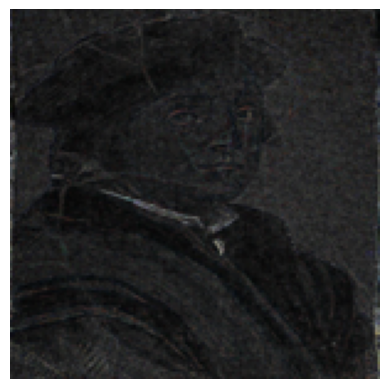

1/1 [==============================] - 0s 19ms/step
selfport.jpg is a crack


In [110]:
# Prediksi lukisan memiliki retakan atau tidak.
## Pinpoint untuk tahap selanjutnya dalam melakukan patching pada lukisan retak
import numpy as np
import matplotlib.pyplot as plt
import cv2

from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array
from PIL import Image

def custom_preprocessing(img):
    # Convert PIL.Image to numpy array
    img = np.array(img)
    
    # Apply your custom preprocessing here
    # Define the kernel size for the top-hat transform
    kernel_size = 10
    # Define the structuring element for the top-hat transform
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    # Perform the top-hat transform to enhance the contrast of the cracks
    tophat = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel)
    # Define the kernel size for the dilation operation
    kernel_size = 3
    # Define the structuring element for the dilation operation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    # Perform the dilation operation to expand the boundaries of the cracks
    dilated = cv2.dilate(tophat, kernel)
    # Convert numpy array to PIL.Image
    dilated = Image.fromarray(dilated)
    # Return the preprocessed image
    return dilated

uploaded = files.upload()

for fn in uploaded.keys():
  
  # Load and preprocess the image
  img = load_img('/content/' + fn)
  img = custom_preprocessing(img)
  img = img.resize((150, 150))
  
  # Display the image
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  # Predict the class label
  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  # Print the prediction result
  if classes[0] > 0.5:
    print(fn + " is a non-crack")
  else:
    print(fn + " is a crack")


Text(0.5, 1.0, 'Training and validation loss')

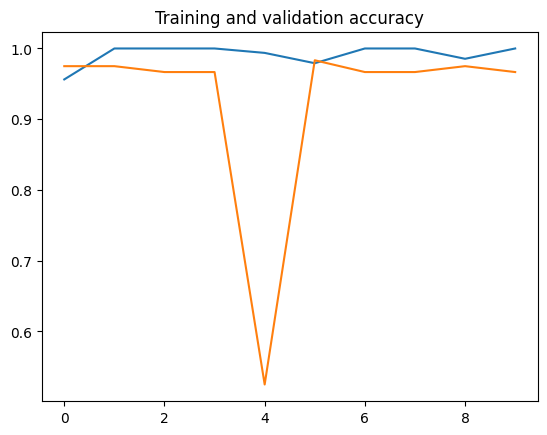

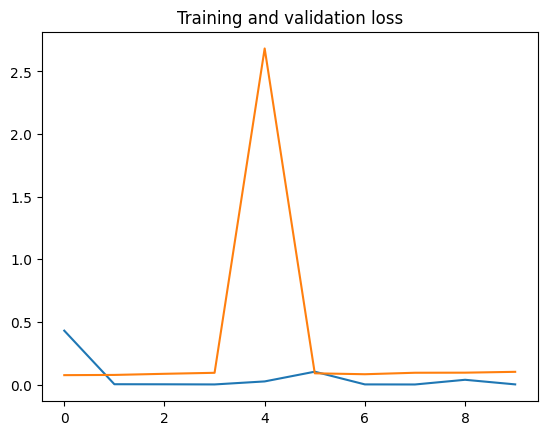

In [113]:

acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) 

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

In [ ]:
model.save('my_model.h5')